In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm.notebook import tqdm as tqdm_notebook
from statsmodels.stats.proportion import proportion_confint

# Критерии

In [2]:
def ttest(sample_a, sample_b, z_sig):
    
    mean_sample_a = np.mean(sample_a)
    mean_sample_b = np.mean(sample_b)
    diff_mean = mean_sample_b - mean_sample_a
    
    std_error_a = np.var(sample_a)/len(sample_a)
    std_error_b = np.var(sample_b)/len(sample_b)
    diff_mean_std_error = std_error_a + std_error_b
    
    t_stat = diff_mean/np.sqrt(diff_mean_std_error)
    
    if t_stat >= z_sig:
        res = 1
    else:
        res = 0
    
    return res

In [3]:
def bootstrap(sample_a, sample_b, sig, n_samples=1000, func=np.mean):
    
    observed_metric = func(sample_b) - func(sample_a)
    combined_sample = np.concatenate((sample_a, sample_b), axis=None)
    combined_sample_size = len(combined_sample)
    sample_a_size = len(sample_a)
    sample_a_size = len(sample_b)
    boot_list = []
    
    for i in range(0, n_samples):
        boot_sample = np.random.choice(combined_sample, size = combined_sample_size)
        boot_sample_a = boot_sample[0:sample_a_size]
        boot_sample_b = boot_sample[sample_a_size:]
        boot_metric = func(boot_sample_a) - func(boot_sample_b)
        boot_list.append(boot_metric)
        
    final_dist = np.array(boot_list)
    p_value = sum(final_dist >= observed_metric)/len(final_dist)
    
    if p_value <= sig:
        res = 1
    else:
        res = 0
    return res
        

# Синтетические данные

In [ ]:
# Зададим исходные параметры
sig = 0.025 # уровень значимости
scale = 1900 # параметр экспоненциального распределения
mean_a = scale # мат.ожидание генеральной совокупности А
mean_b = scale*1.01 # мат.ожидание генеральной совокупности B
var_a = scale**2 # диспресия генеральной совокупности А
var_b = (scale*1.01)**2 # диспресия генеральной совокупности B
mde = mean_b-mean_a # MDE
z_sig = sps.norm.ppf(1-sig) # 97.5 процентиль стандартного нормального распределения

N = 1000

power_list = []
empirical_power_list = []
sig_list = []
sample_size_list = []
left_real_level_list = []
right_real_level_list = []

# Будем брать выборки размерами от 50000 до 275000 с шагом в 25000
for n in tqdm_notebook(range(50000, 300000, 25000)):

    # считаем теоретическую мощность
    z_power = (z_sig-np.sqrt(n)*mde/np.sqrt(var_a+var_b))
    power = 1-sps.norm.cdf(z_power)

    results = []

    for i in tqdm_notebook(range(N)):

        sample_a = sps.expon(loc=0, scale=mean_a).rvs(n)
        sample_b = sps.expon(loc=0, scale=mean_b).rvs(n)

        res = ttest(sample_a, sample_b, z_sig)
        results.append(res)  

    power_list.append(power)
    empirical_power_list.append(np.mean(results)) #считаем эмпирическую мощность
    sample_size_list.append(n)
    
    # считаем доверительный интервал для вероятности успеха серии испытаний Бернулли
    left_real_level, right_real_level = proportion_confint(count=N*empirical_power_list[-1], 
                                                           nobs=N, 
                                                           alpha=0.05, 
                                                           method='wilson')
    if left_real_level < power and right_real_level > power:
        sig_list.append(1)
    else:
        sig_list.append(0)
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

    power_df_ttest = pd.DataFrame(columns=['power', 'empirical_power_ttest', 
                                           'sig_ttest', 'sample_size', 
                                           'left_real_level_ttest', 'right_real_level_ttest'])
    power_df_ttest['power'] = power_list
    power_df_ttest['empirical_power_ttest'] = empirical_power_list
    power_df_ttest['sig_ttest'] = sig_list
    power_df_ttest['sample_size'] = sample_size_list
    power_df_ttest['left_real_level_ttest'] = left_real_level_list
    power_df_ttest['right_real_level_ttest'] = right_real_level_list
    power_df_ttest.to_csv('ttest.csv', index=False)

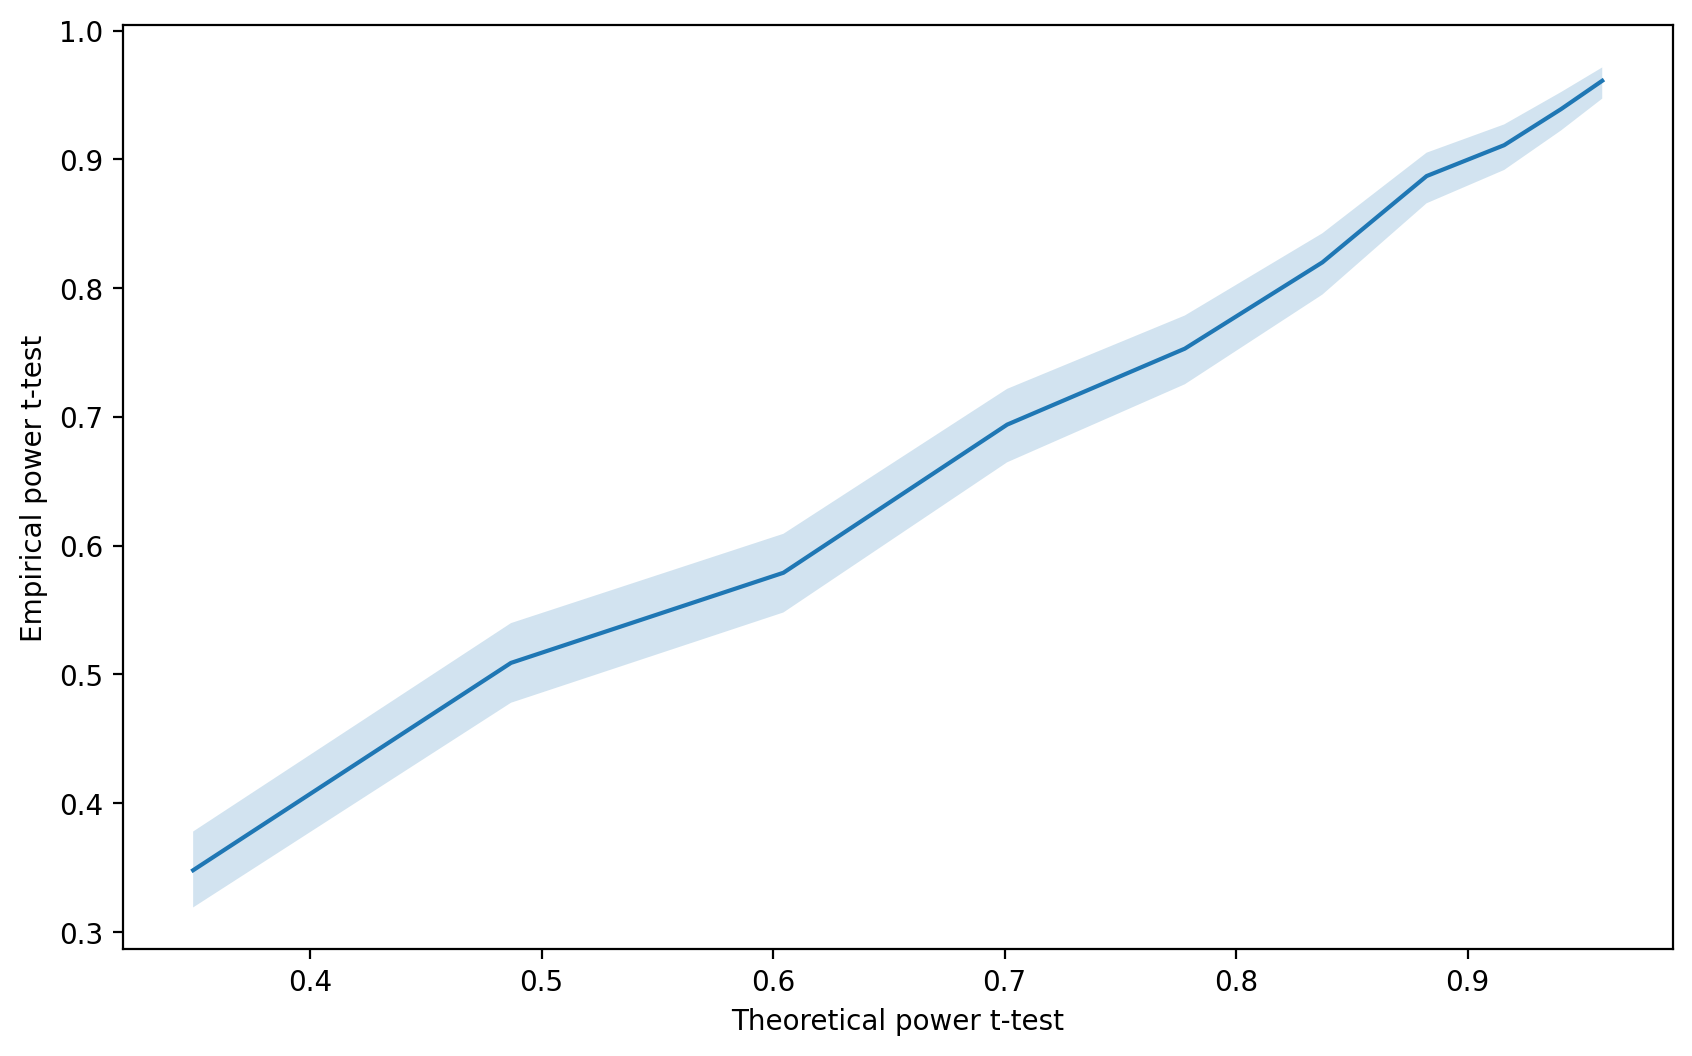

In [6]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(power_df_ttest['power'], power_df_ttest['empirical_power_ttest'], '-')
ax.fill_between(power_df_ttest['power'], 
                power_df_ttest['left_real_level_ttest'], 
                power_df_ttest['right_real_level_ttest'], alpha=0.2)
plt.xlabel('Theoretical power t-test')
plt.ylabel('Empirical power t-test');

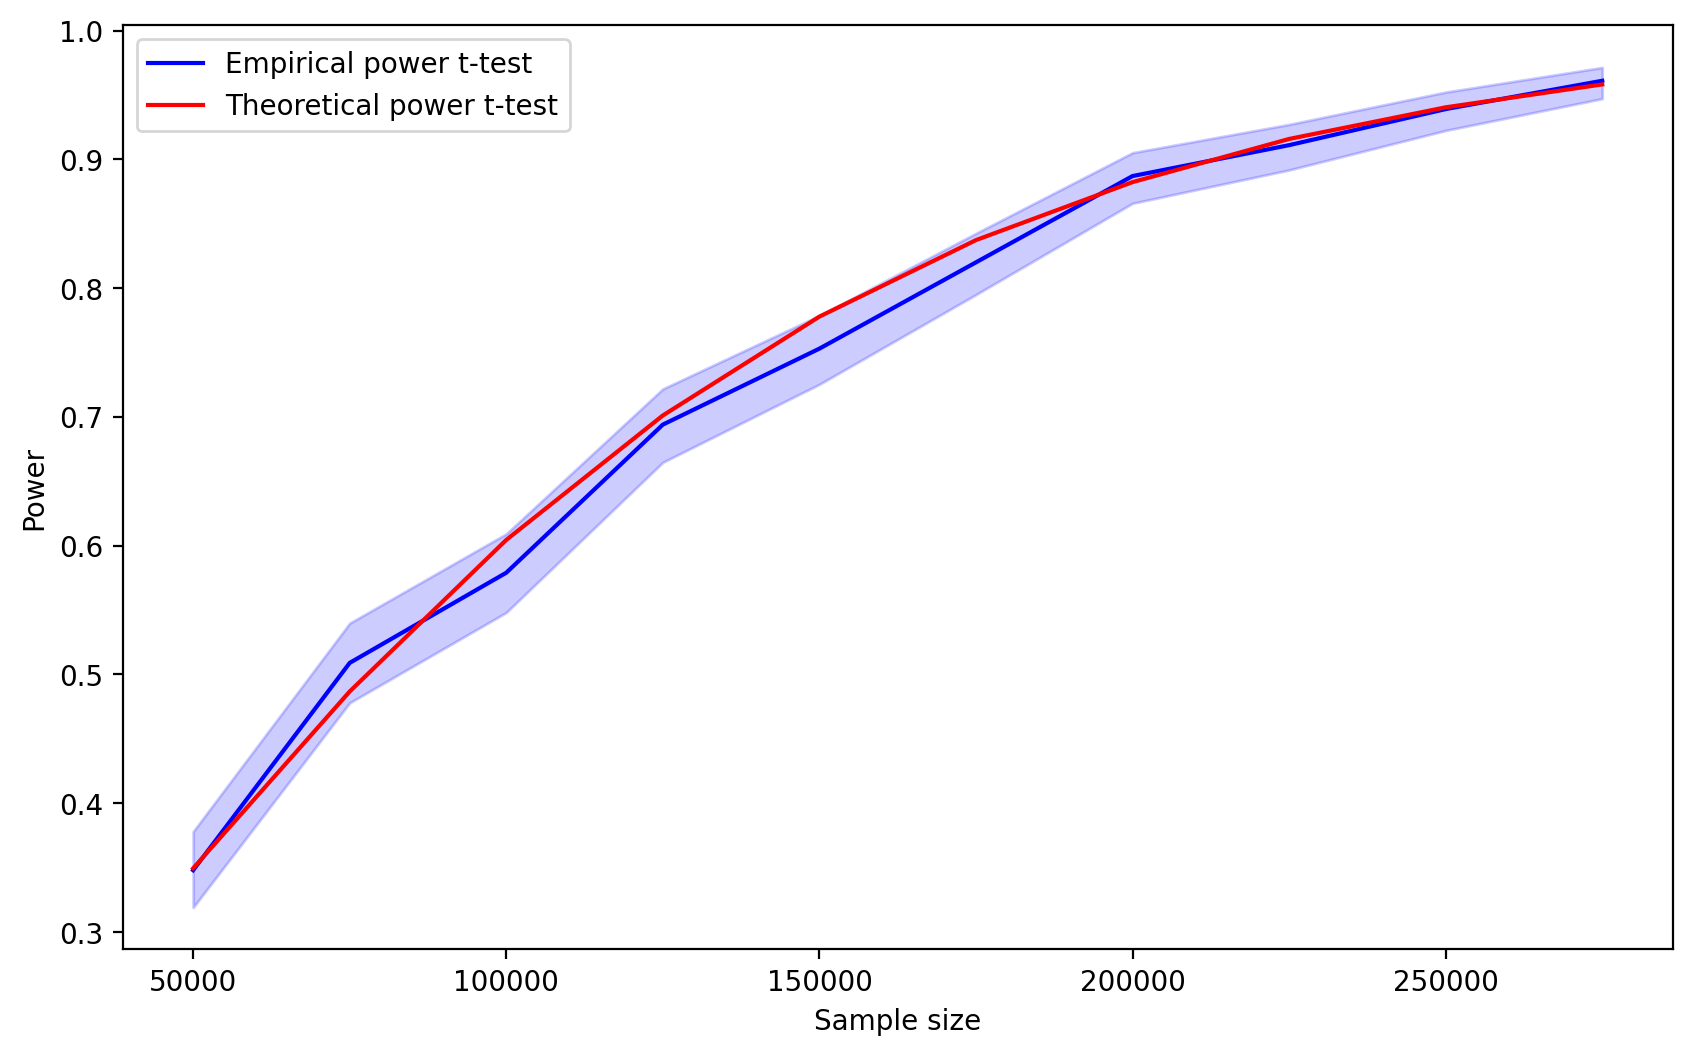

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(power_df_ttest['sample_size'], power_df_ttest['empirical_power_ttest'], '-', 
        label='Empirical power t-test', color='blue')
ax.plot(power_df_ttest['sample_size'], power_df_ttest['power'], '-', 
        label='Theoretical power t-test', color='red')
ax.fill_between(power_df_ttest['sample_size'], power_df_ttest['left_real_level_ttest'], 
                power_df_ttest['right_real_level_ttest'], alpha=0.2, color='blue')
plt.xlabel('Sample size')
plt.ylabel('Power')
ax.legend();

In [25]:
sig = 0.025
mean_a = scale
mean_b = scale*1.01
var_a = scale**2
var_b = (scale*1.01)**2
mde = mean_b-mean_a
z_sig = sps.norm.ppf(1-sig)

N = 1000

power_list = []
empirical_power_list = []
sig_list = []
sample_size_list = []
left_real_level_list = []
right_real_level_list = []

for n in tqdm_notebook(range(50000, 300000, 25000)):

    z_power = (z_sig-np.sqrt(n)*mde/np.sqrt(var_a+var_b))
    power = 1-sps.norm.cdf(z_power)

    results = []

    for i in tqdm_notebook(range(N)):

        sample_a = sps.expon(loc=0, scale=mean_a).rvs(n)
        sample_b = sps.expon(loc=0, scale=mean_b).rvs(n)

        res = bootstrap(sample_a, sample_b, sig)
        results.append(res)  

    power_list.append(power)
    empirical_power_list.append(np.mean(results))
    sample_size_list.append(n)
    left_real_level, right_real_level = proportion_confint(count=N*empirical_power_list[-1], 
                                                           nobs=N, 
                                                           alpha=0.05, 
                                                           method='wilson')
    if left_real_level < power and right_real_level > power:
        sig_list.append(1)
    else:
        sig_list.append(0)
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

    power_df_bootstrap = pd.DataFrame(columns=['power', 'empirical_power_bootstrap', 
                                               'sig_bootstrap', 'sample_size', 
                                               'left_real_level', 'right_real_level'])
    power_df_bootstrap['power'] = power_list
    power_df_bootstrap['empirical_power_bootstrap'] = empirical_power_list
    power_df_bootstrap['sig_bootstrap'] = sig_list
    power_df_bootstrap['sample_size'] = sample_size_list
    power_df_bootstrap['left_real_level_bootstrap'] = left_real_level_list
    power_df_bootstrap['right_real_level_bootstrap'] = right_real_level_list
    power_df_bootstrap.to_csv('bootstrap.csv', index=False)

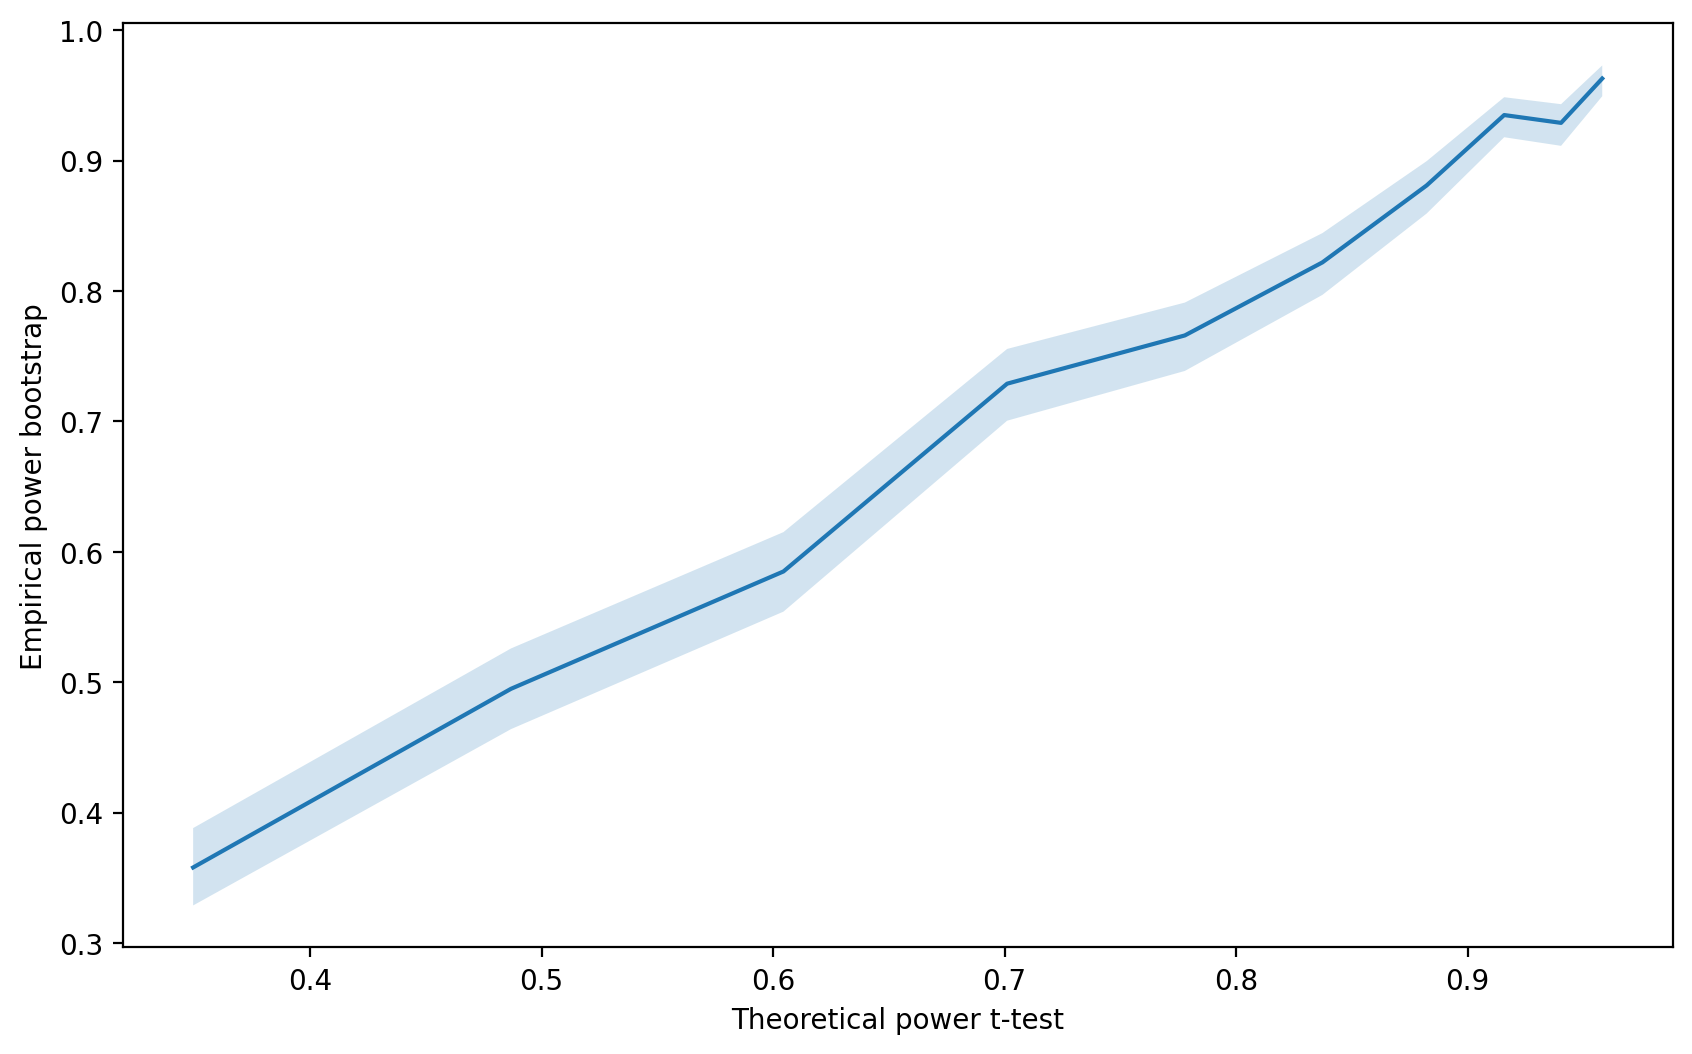

In [26]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(power_df_bootstrap['power'], power_df_bootstrap['empirical_power_bootstrap'], '-')
ax.fill_between(power_df_bootstrap['power'], 
                power_df_bootstrap['left_real_level_bootstrap'], 
                power_df_bootstrap['right_real_level_bootstrap'], alpha=0.2)
plt.xlabel('Theoretical power t-test')
plt.ylabel('Empirical power bootstrap');

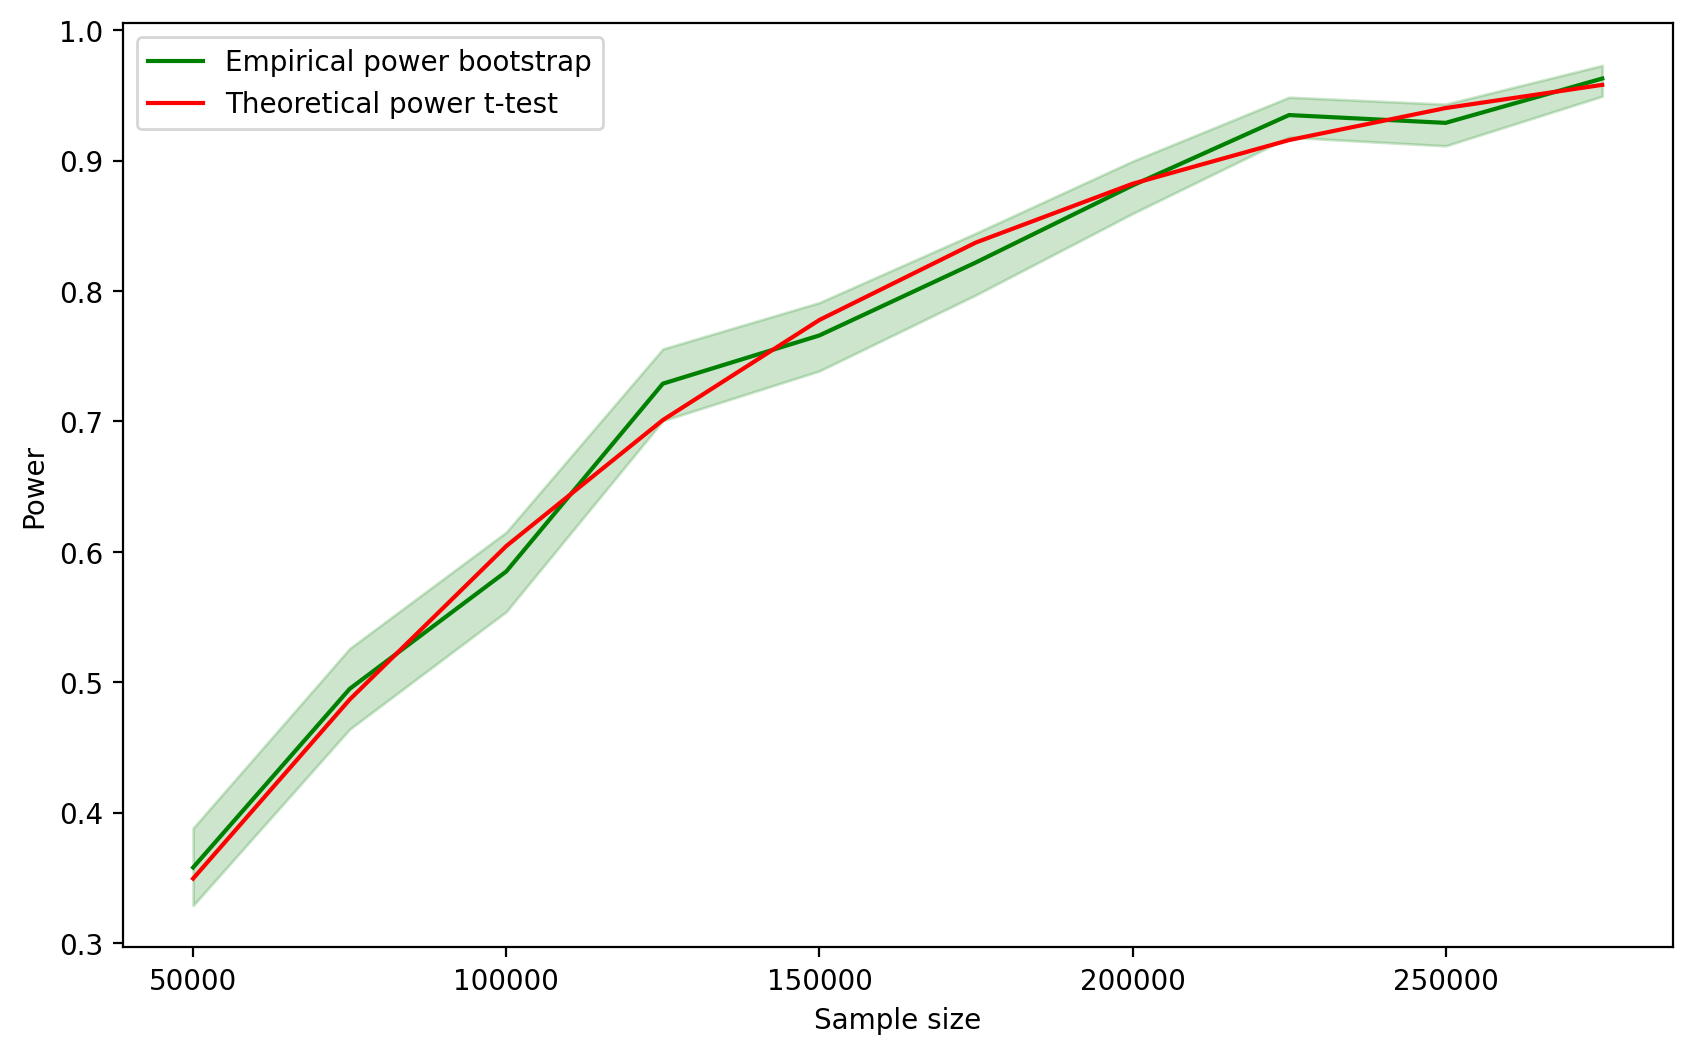

In [27]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(power_df_bootstrap['sample_size'], power_df_bootstrap['empirical_power_bootstrap'], '-', 
        label='Empirical power bootstrap', color='green')
ax.plot(power_df_bootstrap['sample_size'], power_df_bootstrap['power'], '-', 
        label='Theoretical power t-test', color='red')
ax.fill_between(power_df_bootstrap['sample_size'], power_df_bootstrap['left_real_level_bootstrap'], 
                power_df_bootstrap['right_real_level_bootstrap'], alpha=0.2, color='green')
plt.xlabel('Sample size')
plt.ylabel('Power')
ax.legend();

In [28]:
power_df = pd.merge(power_df_ttest, power_df_bootstrap, how='inner', on=['power', 'sample_size'])
power_df.set_index(pd.Index(range(50000, 300000, 25000)), inplace=True)

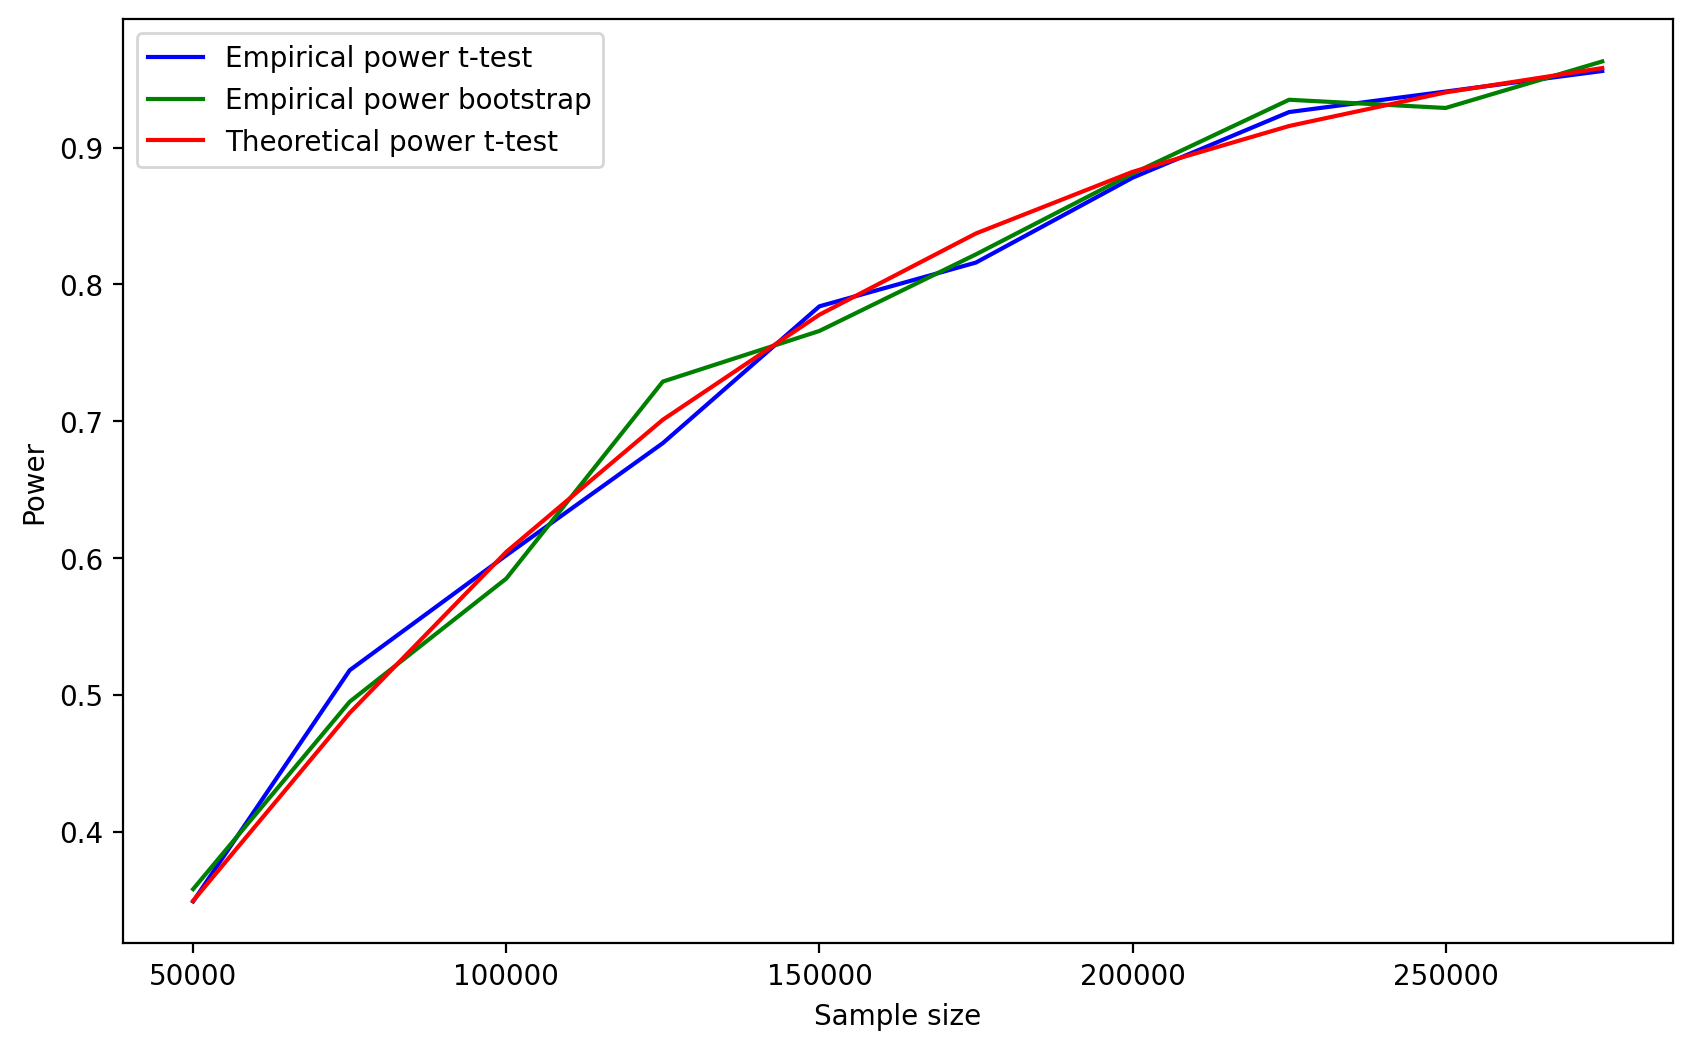

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(power_df['sample_size'], power_df['empirical_power_ttest'], '-', 
        label='Empirical power t-test', color='blue')
ax.plot(power_df['sample_size'], power_df['empirical_power_bootstrap'], '-', 
        label='Empirical power bootstrap', color='green')
ax.plot(power_df['sample_size'], power_df['power'], '-', 
        label='Theoretical power t-test', color='red')
# ax.fill_between(power_df['sample_size'], power_df['left_real_level_ttest'], 
#                 power_df['right_real_level_ttest'], alpha=0.2, color='blue')
# ax.fill_between(power_df['sample_size'], power_df['left_real_level_bootstrap'], 
#                 power_df['right_real_level_bootstrap'], alpha=0.2, color='green')
plt.xlabel('Sample size')
plt.ylabel('Power')
ax.legend();

# Реальные данные

In [31]:
sig = 0.05
power = 0.8
z_power, z_sig = sps.norm.ppf([1-power, 1-sig])

fake_population_a = np.array() # сюда вставляем выборку полученную на основе реальных данных
fake_population_a_mean = fake_population_a.mean()
fake_population_a_var = fake_population_a.var()

rel_mde_list = [0.05, 0.04, 0.03, 0.02] # относительные значения прироста (относительный MDE)

N = 1000

power_list = []
empirical_power_list = []
sig_list = []
mde_list = []
sample_size_list = []
left_real_level_list = []
right_real_level_list = []


for rel_mde in tqdm_notebook(rel_mde_list):

    mde = fake_population_a_mean*rel_mde
    fake_population_b = fake_population_a + mde
    fake_population_b_mean = fake_population_a_mean + mde
    fake_population_b_var = fake_population_a_var

    n = (fake_population_a_var + fake_population_b_var)*((z_sig - z_power)**2)/(mde**2)
    n = round(n)

    results = []

    for i in tqdm_notebook(range(N)):

        sample_a = np.random.choice(fake_population_a, size = n, replace = False)
        sample_b = np.random.choice(fake_population_b, size = n, replace = False)

        res = ttest(sample_a, sample_b, z_sig)
        results.append(res)  

    power_list.append(power)
    empirical_power_list.append(np.mean(results))
    mde_list.append(rel_mde)
    sample_size_list.append(n)
    left_real_level, right_real_level = proportion_confint(count = N*empirical_power_list[-1], 
                                                           nobs = N, 
                                                           alpha=0.05, 
                                                           method='wilson')
    if left_real_level < power and right_real_level > power:
        sig_list.append(1)
    else:
        sig_list.append(0)
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

    power_df_ttest_real = pd.DataFrame(columns=['power', 'empirical_power_ttest', 
                                                'sig_ttest', 'mde', 'sample_size', 
                                                'left_real_level_ttest', 'right_real_level_ttest'])
    power_df_ttest_real['power'] = power_list
    power_df_ttest_real['empirical_power_ttest'] = empirical_power_list
    power_df_ttest_real['sig_ttest'] = sig_list
    power_df_ttest_real['mde'] = mde_list
    power_df_ttest_real['sample_size'] = sample_size_list
    power_df_ttest_real['left_real_level_ttest'] = left_real_level_list
    power_df_ttest_real['right_real_level_ttest'] = right_real_level_list
    power_df_ttest_real.to_csv('real_data_ttest.csv', index = False)

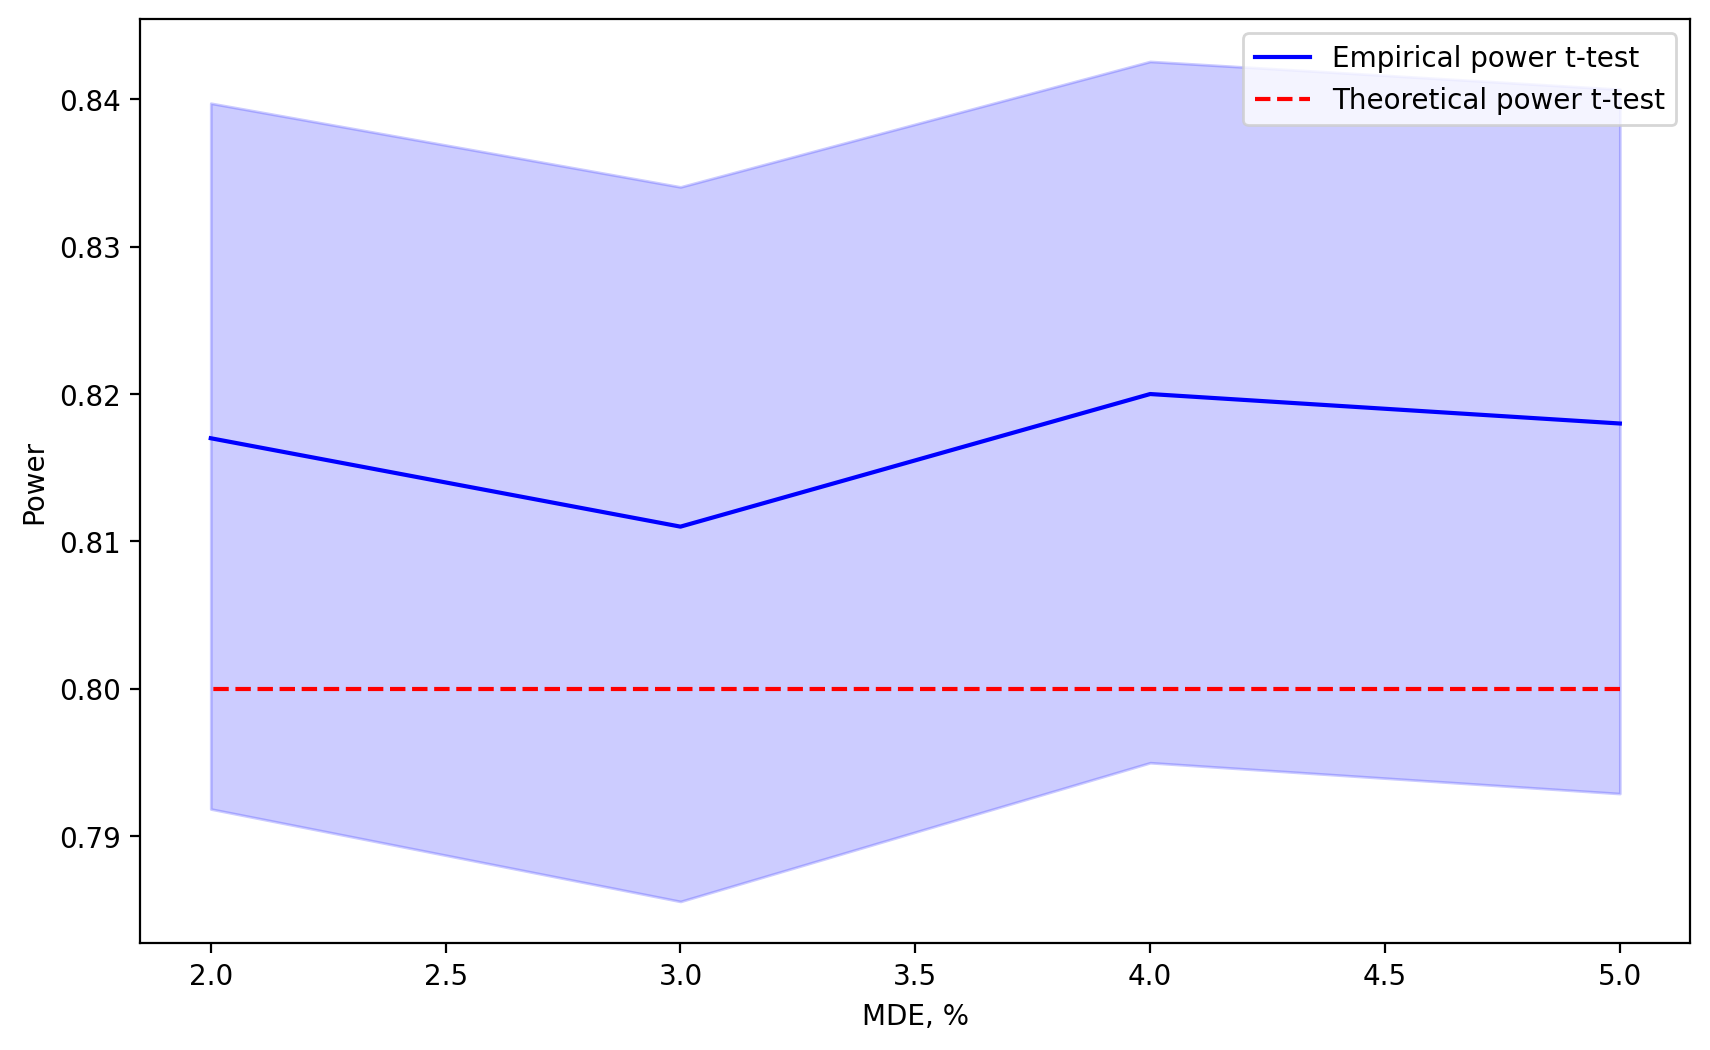

In [34]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(100*power_df_ttest_real['mde'], power_df_ttest_real['empirical_power_ttest'], '-', 
        label='Empirical power t-test', color='blue')
ax.plot(100*power_df_ttest_real['mde'], power_df_ttest_real['power'], '--', 
        label='Theoretical power t-test', color='red')
ax.fill_between(100*power_df_ttest_real['mde'], power_df_ttest_real['left_real_level_ttest'], 
                power_df_ttest_real['right_real_level_ttest'], alpha=0.2, color='blue')
plt.xlabel('MDE, %')
plt.ylabel('Power')
ax.legend();

In [35]:
sig = 0.05
power = 0.8
z_power, z_sig = sps.norm.ppf([1-power, 1-sig])

fake_population_a = np.array() # сюда вставляем выборку полученную на основе реальных данных
fake_population_a_mean = fake_population_a.mean()
fake_population_a_var = fake_population_a.var()

rel_mde_list = [0.05, 0.04, 0.03, 0.02] # относительные значения прироста (относительный MDE)

N = 1000

power_list = []
empirical_power_list = []
sig_list = []
mde_list = []
sample_size_list = []
left_real_level_list = []
right_real_level_list = []

for rel_mde in tqdm_notebook(rel_mde_list):

    # задаем фейковую генеральную совокупность B
    mde = fake_population_a_mean*rel_mde
    fake_population_b = fake_population_a + mde
    fake_population_b_mean = fake_population_a_mean + mde
    fake_population_b_var = fake_population_a_var

    n = (fake_population_a_var + fake_population_b_var)*((z_sig - z_power)**2)/(mde**2)
    n = round(n)

    results = []

    for i in tqdm_notebook(range(N)):

        sample_a = np.random.choice(fake_population_a, size = n, replace = False)
        sample_b = np.random.choice(fake_population_b, size = n, replace = False)

        res = bootstrap(sample_a, sample_b, sig)
        results.append(res)  

    power_list.append(power)
    empirical_power_list.append(np.mean(results))
    mde_list.append(rel_mde)
    sample_size_list.append(n)
    left_real_level, right_real_level = proportion_confint(count = N*empirical_power_list[-1], 
                                                           nobs = N, 
                                                           alpha=0.05, 
                                                           method='wilson')
    if left_real_level < power and right_real_level > power:
        sig_list.append(1)
    else:
        sig_list.append(0)
    left_real_level_list.append(left_real_level)
    right_real_level_list.append(right_real_level)

    power_df_bootstrap_real = pd.DataFrame(columns=['power', 'empirical_power_bootstrap', 
                                                    'sig_bootstrap', 'mde', 'sample_size', 
                                                    'left_real_level_bootstrap', 'right_real_level_bootstrap'])
    power_df_bootstrap_real['power'] = power_list
    power_df_bootstrap_real['empirical_power_bootstrap'] = empirical_power_list
    power_df_bootstrap_real['sig_bootstrap'] = sig_list
    power_df_bootstrap_real['mde'] = mde_list
    power_df_bootstrap_real['sample_size'] = sample_size_list
    power_df_bootstrap_real['left_real_level_bootstrap'] = left_real_level_list
    power_df_bootstrap_real['right_real_level_bootstrap'] = right_real_level_list
    power_df_bootstrap_real.to_csv('real_data_bootstrap.csv', index = False)

In [36]:
power_df_real = pd.merge(power_df_ttest_real, power_df_bootstrap_real, 
                         how='inner', on=['mde', 'power'], suffixes=('_ttest', '_bootstrap'))

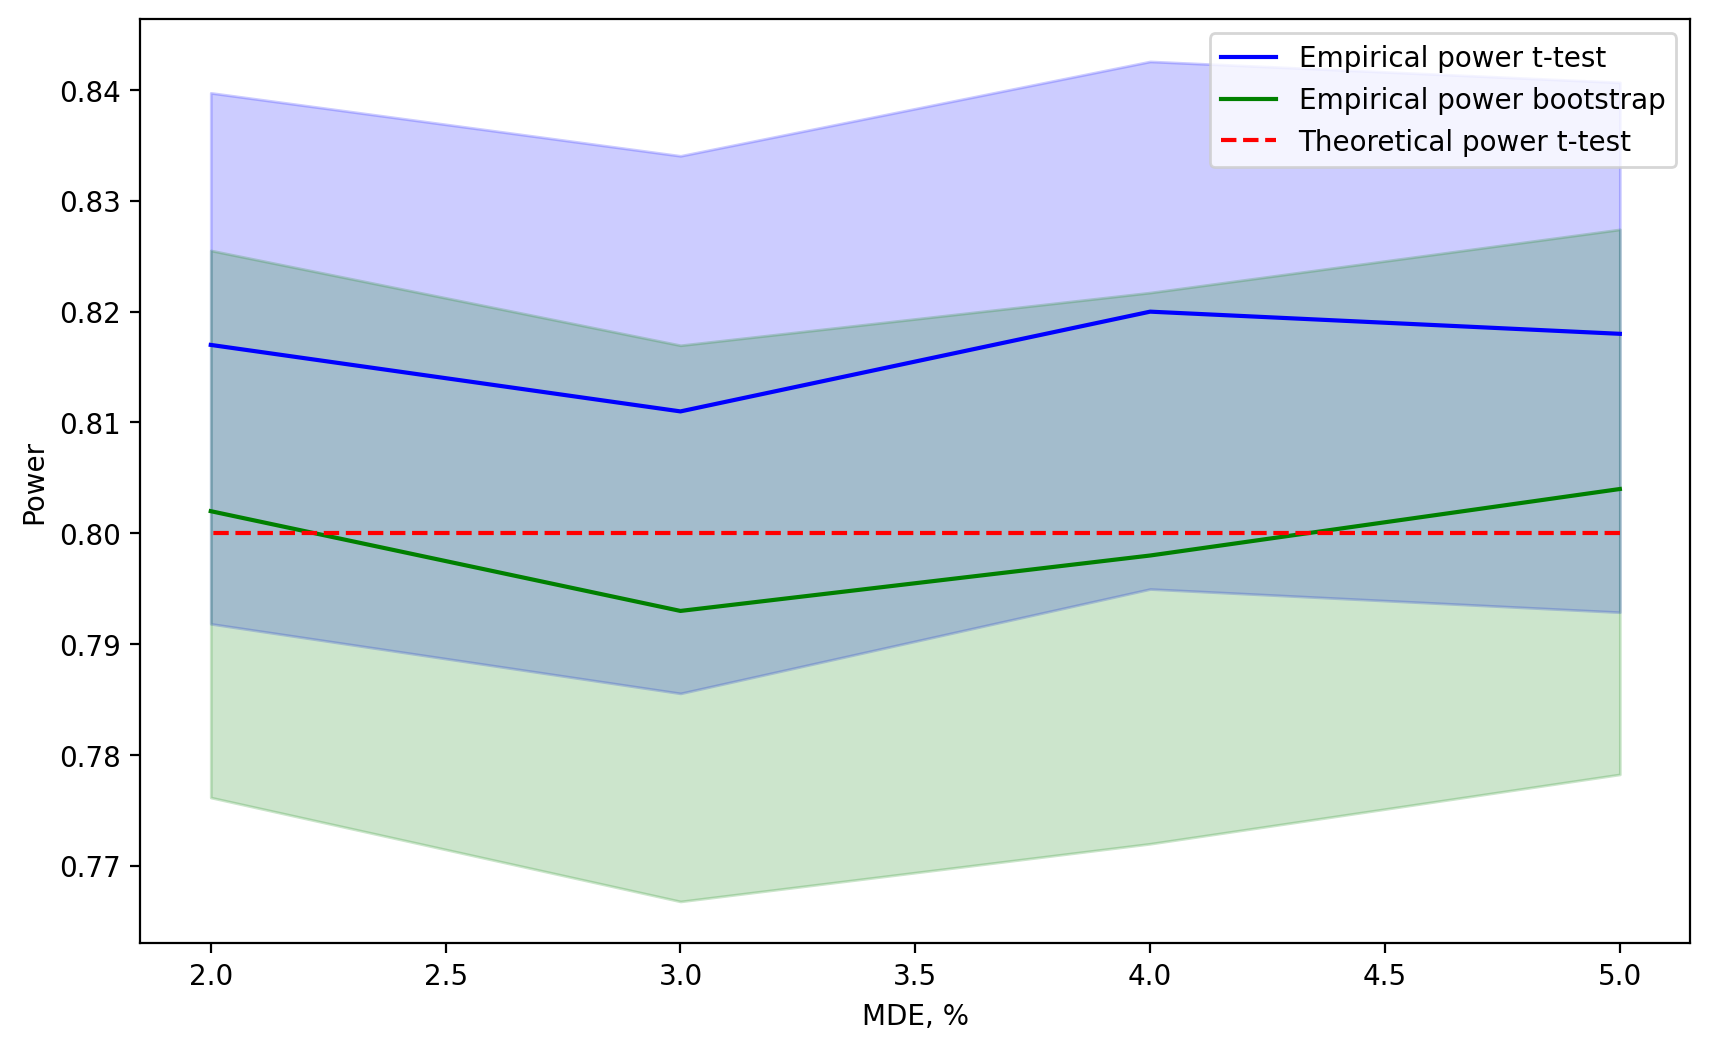

In [40]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(100*power_df_real['mde'], power_df_real['empirical_power_ttest'], '-', 
        label='Empirical power t-test', color='blue')
ax.plot(100*power_df_real['mde'], power_df_real['empirical_power_bootstrap'], '-', 
        label='Empirical power bootstrap', color='green')
ax.plot(100*power_df_real['mde'], power_df_real['power'], '--', 
        label='Theoretical power t-test', color='red')
ax.fill_between(100*power_df_real['mde'], power_df_real['left_real_level_ttest'], 
                power_df_real['right_real_level_ttest'], alpha=0.2, color='blue')
ax.fill_between(100*power_df_real['mde'], power_df_real['left_real_level_bootstrap'], 
                power_df_real['right_real_level_bootstrap'], alpha=0.2, color='green')
plt.xlabel('MDE, %')
plt.ylabel('Power')
ax.legend();